<a href="https://colab.research.google.com/github/msb1002/models/blob/master/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Models Pipeline

Sun Bin MUN

If the data are used in STOOQ, skip step 2 and 
go directly to Step 3 - model validation

##1. Library Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import os.path as osp
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
import time, matplotlib, torch, os
from statsmodels.tsa.arima_model import ARIMA
from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import os
from os import walk

import plotly
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
#import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
#For DNN / CNN+LSTM
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Flatten, Dense

In [ ]:
#For SVR
from sklearn.svm import SVR

#For SVM
from sklearn import svm
from sklearn.svm import SVC

In [ ]:
#For ARIMA
import math
import warnings
warnings.filterwarnings('ignore')
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.2 MB/s 


In [ ]:
#For CNN - LSTM
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import InputLayer, ConvLSTM1D, LSTM, Flatten, RepeatVector, Dense, TimeDistributed
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import keras.backend as K
#from keras.losses import Huber

##2. Data Preprocessing


In [ ]:
#@title
DIR = '/content/drive/MyDrive/COMP_4981'

#List of datasets
dataset_folders = os.listdir(DIR)[1:]
print(dataset_folders.sort())

None


In [ ]:
def finder(ds,target):
  for e in ds:
    if code in e:
      return e

def timestamp(i):
  formatted_date = datetime.fromtimestamp(i)
  return formatted_date

In [ ]:
code = input()+'.csv'
filename = f'{DIR}/'+finder(dataset_folders,code)
df = pd.read_csv(filename)
df.head()

2000


,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [ ]:
#Modify timestamp
x = df['timestamp'].apply(lambda x: timestamp(x))
df['date'] = x
df.set_index(df['date'], inplace=True)
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
#Leave olhc
df.set_index('date', inplace=True)
df_olhcv = df[['Open','High','Low','Close','Volume']]

##2 b) Using pandas datareader for analysis

In [ ]:
import pandas_datareader.data as web

#Setting the index values as timestamp
def process():
  print("Enter the code of the model that you want to implement")
  code = input()
  #final_code = '^'+code
  final_code = code
  df_ = web.DataReader(final_code, 'stooq')
  #df_['timestamp'] = df_.index.astype('int64')
  df_.reset_index(drop=True, inplace=True)
  #df_.set_index('timestamp', inplace=True)

  print(f"Loading the dataset for the {code}")

  return df_


Reference : https://github.com/SaahilMadge-zz/Spring-2015-IW/blob/master/techsectoranalysis.py


In [ ]:
def additional_features(df):
  #SMA
  df['10_sma'] = df['Close'].rolling(window=10,min_periods=1).mean()
  df['20_sma'] = df['Close'].rolling(window=20,min_periods=1).mean()
  df['50_sma'] = df['Close'].rolling(window=50,min_periods=1).mean()
  
  #EMA
  df['10_ema'] = df['Close'].ewm(span=10,min_periods=1).mean()
  df['20_ema'] = df['Close'].ewm(span=20,min_periods=1).mean()
  df['50_ema'] = df['Close'].ewm(span=50,min_periods=1).mean()

  #Bollinger
  df['bollinger_mean'] = df['Close'].rolling(20, min_periods=1).mean()
  df['bollinger_std'] = df['Close'].rolling(20, min_periods=1).std()
  df['BOL_UP'] = df['bollinger_mean'] + (2 * df['bollinger_std'])
  df['BOL_DOWN'] = df['bollinger_mean'] - (2 * df['bollinger_std'])
  df["bollinger_gap"] = df["BOL_UP"]-df['BOL_DOWN']
  df.dropna(inplace=True) #Not sure if I can change?

  price_change =  df['Close'].pct_change().fillna(0)
  df['percetage_change'] = price_change

  momentum = [1,1]
  for i in range(2,len(df)):
    momentum.append(1 if df['Close'][i] > df['Close'][i-1] else -1)
  df['momentum'] = momentum

In [ ]:
#Print the database for the implementations

df = process()
additional_features(df)
df.head()

Enter the code of the model that you want to implement
AAPL
Loading the dataset for the AAPL


,Open,High,Low,Close,Volume,10_sma,20_sma,50_sma,10_ema,20_ema,50_ema,bollinger_mean,bollinger_std,BOL_UP,BOL_DOWN,bollinger_gap,percetage_change,momentum
1,172.8900,174.14,171.03,172.17,86709147,172.180000,172.180000,172.180000,172.179000,172.179500,172.179800,172.180000,0.014142,172.208284,172.151716,0.056569,0.000000,1
2,172.6335,175.30,171.64,172.00,96903955,172.120000,172.120000,172.120000,172.107043,172.113589,172.117454,172.120000,0.104403,172.328806,171.911194,0.417612,-0.000987,1
3,179.6100,180.17,174.64,174.92,94537602,172.820000,172.820000,172.820000,173.033787,172.923756,172.860678,172.820000,1.402593,175.625186,170.014814,5.610371,0.016977,-1
4,182.6300,182.94,179.12,179.70,99310438,174.196000,174.196000,174.196000,174.947476,174.562872,174.340114,174.196000,3.307919,180.811839,167.580161,13.231677,0.027327,1
5,177.8300,182.88,177.71,182.01,104701220,175.498333,175.498333,175.498333,176.781857,176.133876,175.749597,175.498333,4.350896,184.200125,166.796541,17.403584,0.012855,1


## 3. Model Selections (in function)

For demonstration, all the models are from STOOQ for simplicity. Implement Step 1,2 for latter versions

Further references - https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-stooq


## 3 a) SVR

In [ ]:
from sklearn.svm import SVR

def svr_func(df_):
  train_df = df_
  #Data Preprocessing
  train_df_svr = train_df.head(len(train_df)-1) 
  days = train_df_svr.index.tolist()
  days = [[i] for i in days]
  #adj_prices = [[i] for i in adj_prices]
  adj_prices = train_df_svr['Close'].tolist()
  train_X, test_X, train_y, test_y = train_test_split(days, adj_prices, test_size=0.25)

  #SVR Models-1
  #lin_svr = SVR(kernel='linear',C=1000.0)
  #lin_svr.fit(train_X,train_y)

  #SVR Models-2
  poly_svr = SVR(kernel='poly',C=1000.0, degree=2)
  poly_svr.fit(train_X,train_y)

  #SVR Models-3
  rbf_svr = SVR(kernel='rbf',C=1000.0, gamma = 0.15)
  rbf_svr.fit(train_X,train_y)

  #performance evaluation

  print("Pure prediction section")
  print("Actual score - poly")
  print(poly_svr.score(test_X, test_y))
  print("Actual score - rbf")
  print(rbf_svr.score(test_X, test_y))

  print("------------------------------------")
  #svr_list = [lin_svr,poly_svr,rbf_svr]
  svr_list = [poly_svr,rbf_svr]
  for svr in svr_list:
    svr_predict = svr.predict(test_X)

    print('SVR {} PERFORMANCE'.format(str(svr)))
    print('r2 score: '+str(r2_score(test_y, svr_predict)))
    print('RMSE : '+str(np.sqrt(mean_squared_error(test_y, svr_predict))))
    print("Mean Absolute Error : " + str(mean_absolute_error(test_y,svr_predict)))


def svm_func(df_):

  print("Momentum prediction - as classifier")

  length = len(df)

  X = np.transpose(np.array([df['percetage_change'],df['bollinger_gap'],df['bollinger_mean'],df['bollinger_std']]))
  Y = np.array(df['momentum'])

  X_train = X[0:int(0.8*length)]
  X_test = X[int(0.8*length):]
  y_train = Y[0:int(0.8*length)]
  y_test = Y[int(0.8*length):]


  poly_svm = svm.SVC(kernel='poly')
  poly_svm.fit(X_train, y_train)
  poly_score = poly_svm.score(X_test, y_test)
  print("Prediction score for poly SVM classifier : ",poly_score)

  rbf_svm = svm.SVC(kernel='rbf')
  rbf_svm.fit(X_train, y_train)
  rbf_score = rbf_svm.score(X_test, y_test)
  print("Prediction score for RBF SVM classifier : ",rbf_score)



In [ ]:
df = process()
additional_features(df)

Enter the code of the model that you want to implement
AAPL


In [ ]:
import pandas as pd
from sklearn import svm

svr_func(df)

Pure prediction section
Actual score - poly
0.6017115370987292
Actual score - rbf
0.9947189276683958
------------------------------------
SVR SVR(C=1000.0, degree=2, kernel='poly') PERFORMANCE
r2 score: 0.6017115370987292
RMSE : 26.165288115024303
Mean Absolute Error : 20.78294217528931
SVR SVR(C=1000.0, gamma=0.15) PERFORMANCE
r2 score: 0.9947189276683958
RMSE : 3.0129208020039013
Mean Absolute Error : 1.6942414477853822


In [ ]:
svm_func(df)

Momentum prediction - as classifier
Prediction score for poly SVM classifier :  0.5476190476190477
Prediction score for RBF SVM classifier :  0.5476190476190477


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 1002)

tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf'],'C': [1,100,1000]}]

clf = GridSearchCV(SVC(), tuned_parameters, scoring='accuracy')
clf.fit(train_X, train_y)

clf.best_params_

NameError: ignored

In [ ]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

Reference : https://stackoverflow.com/questions/62346013/svc-object-has-no-attribute-svc


In [ ]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
clf.cv_results_['params']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.565 (+/-0.048) for {'C': 1, 'kernel': 'linear'}
0.556 (+/-0.004) for {'C': 1, 'kernel': 'poly'}
0.556 (+/-0.004) for {'C': 1, 'kernel': 'rbf'}


## 3 b) DNN Model (pure)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
#Data Pre-processing
train_df = df

X = train_df[['Open','High','Low','Volume']]
Y = train_df[['Close']]

X_scaler = MinMaxScaler(feature_range=(0, 1))
X[X.columns] = X_scaler.fit_transform(X[X.columns])
X = X.fillna(X.median())

Y_scaler = MinMaxScaler(feature_range=(0, 1))
Y[Y.columns] = Y_scaler.fit_transform(Y[Y.columns])
Y = Y.fillna(Y.median())

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.25)

In [ ]:
#Model
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu", input_shape=(4,)),
        layers.Dense(128, activation="relu", name="layer1"),
        layers.Dense(256, activation="relu", name="layer2"),
        layers.Dense(1,activation="linear", name="layer3")
    ]
)

model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(train_X,train_y,validation_data=(val_X, val_y),epochs = 200 ,batch_size = 10,verbose=False)

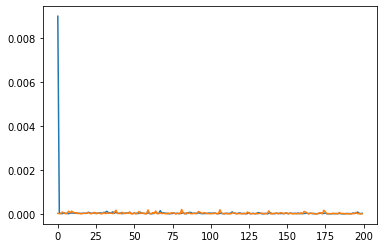

In [ ]:
history_df = pd.DataFrame(history.history)
history_df['loss'].plot();
history_df['val_loss'].plot();
plt.title("Simple DNN Architecture")

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                320       
                                                                 
 layer1 (Dense)              (None, 128)               8320      
                                                                 
 layer2 (Dense)              (None, 256)               33024     
                                                                 
 layer3 (Dense)              (None, 1)                 257       
                                                                 
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dnn_predict = model.predict(test_X)

print('SIMPLE DNN PERFORMANCE')
print('r2 score: '+str(r2_score(test_y, dnn_predict)))
print('RMSE : '+str(np.sqrt(mean_squared_error(test_y, dnn_predict))))
print("Mean Absolute Error : " + str(mean_absolute_error(test_y,dnn_predict)))


SIMPLE DNN PERFORMANCE
r2 score: 0.9996283879928268
RMSE : 0.0050040235595410236
Mean Absolute Error : 0.0034069171659931907


### 3 c) Complex DNN Model

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.25)
train_X,val_X,train_y,val_y = train_test_split(train_X, train_y, test_size=0.25)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium change considered improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

#train_X, test_X, train_y, test_y
model = keras.Sequential([
    layers.Dense(units=1024, input_shape=[len(train_X.columns)]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1)

])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=256,
    epochs=200,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=True
)

Text(0.5, 1.0, 'Complex DNN Structure')

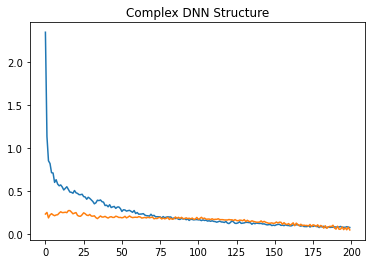

In [ ]:
#Expressing the loss - underfitting
history_df = pd.DataFrame(history.history)
history_df['loss'].plot();
history_df['val_loss'].plot();
plt.title("Complex DNN Structure")

## 3 c) XGBoost


In [ ]:
from xgboost import XGBRegressor

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2)
model = XGBRegressor(learning_rate = 0.01,n_estimators=1000)

model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)
xgb_pred_y = model.predict(test_X)

[17:17:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Performance evaluation
print('XGBOOST PERFORMANCE')
print('r2 score: '+str(r2_score(test_y, xgb_pred_y)))
print('RMSE : '+str(np.sqrt(mean_squared_error(test_y, xgb_pred_y))))
print("Mean Absolute Error : " + str(mean_absolute_error(test_y,xgb_pred_y)))

XGBOOST PERFORMANCE
r2 score: 0.9986942559752144
RMSE : 0.008269744040337553
Mean Absolute Error : 0.005616374277021515


## 3 d) CatBoost

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(random_state=1002,logging_level='Silent')

model_cat.fit(train_X, train_y, plot=True)
pred_cat = model_cat.predict(test_X, verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
#Performance evaluation
print('CATBoost PERFORMANCE')
print('r2 score: '+str(r2_score(test_y, pred_cat)))
print('RMSE : '+str(np.sqrt(mean_squared_error(test_y, pred_cat))))
print("Mean Absolute Error : " + str(mean_absolute_error(test_y,pred_cat)))

CATBoost PERFORMANCE
r2 score: 0.9985437550211245
RMSE : 0.008733337919420405
Mean Absolute Error : 0.005950686297095928


## 3 e) ARIMA

Reference

ARIMA - Auto Regression Integrated Moving Average (AR, I, MA)

**p**: order of the autoregressive model (how lagged it is) -> # of preceding Y values that needs to be added

**d**: degree of differencing (How much the value is different from the previous) -> d until it makes data stationary (const variance)

e.g. 

If d=1:  yt  =  Yt - Yt-1

If d=2:  yt  =  (Yt - Yt-1) - (Yt-1 - Yt-2)  = Yt - 2Yt-1 + Yt-2

**q** : Order of moving average (MA) - error terms (adding the noise)

Criteria 

- ACF,PACF graph : appropriateness of the model
- AIC : Lowest
- BIC : Lowest

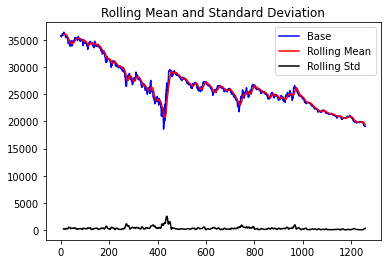

Results of dickey fuller test
Test Statistics           -1.668351
p-value                    0.447488
# lags                     9.000000
# observations used     1248.000000
critical value (1%)       -3.435601
critical value (5%)       -2.863859
critical value (10%)      -2.568004
dtype: float64


In [ ]:
df_close = df['Close']

#For the ADF test

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() #window size 12 mean

    rolstd = timeseries.rolling(12).std() #windoiw size 12 std
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Base')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    # Resulting test statistics, p-value, lags used and number of observation
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','# lags','# observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Unit Root Test : 
Time Series y_t = D_t + z_t + e_t
- D_t : Deterministic (trend,season)
- z_t : stochastic (random walk with a drift) **testing this part**
- e_t : stationary error

Model with unit root has a "spike and shocks" = high unit root means highly stochastic


Critical value (1%,5%,10% C.I) < Test Statistics

H_0 : (O) unit root exists vs H_a : (X) unit root does not exist

NOT Stationary

<Figure size 432x288 with 0 Axes>

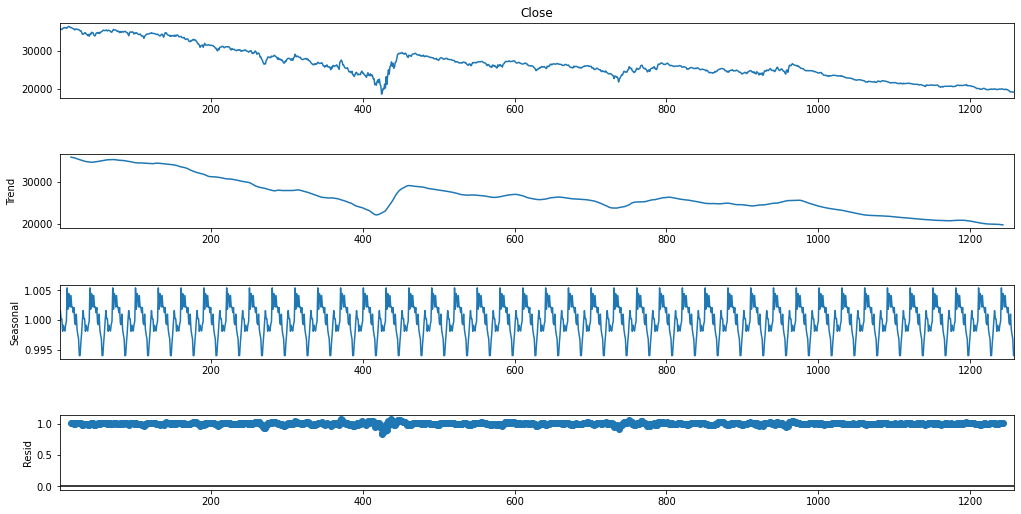

In [ ]:
#The data is non-linear
#Analyzing the Close, Trend, and seasonality
result = seasonal_decompose(df_close, model='multiplicative', period = 30)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 8)

Based on the graph above, it is evident that there is a downward trend in Close price, meaning that the data is **not stationary**

- mean should be stationary over time
- variance should not be function of time (homoscedasticity)
-covariance should not be function of time



Methods to make data stationary : https://people.duke.edu/~rnau/whatuse.htm

In [ ]:
#Log,Differencing to make it stationary - Transformations such as logarithms can help to stabilise the variance of a time series. 
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

#Separating the training and testing
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]


Autocorrelation : relationship between the lags (serial correlation)
- X axis : # of lags
- Y axis : Moran's I (how one is similar to surrounding)

Below

- ACF : Quite close to one another and is all in one side
-PACF : Part of y(t) vs y(t-2) not explained by y(t-1)

AR : ACF decrease slowly & PACF sharp drop

MA : ACF sharp drop & PACF gradual decline

ARMA : moth ACF & PACF decrease

e.g. 둘 다 서서히 줄어들면 ARMA(1,1), ACF에서 두번 쭉 떨어지면 MA(2)

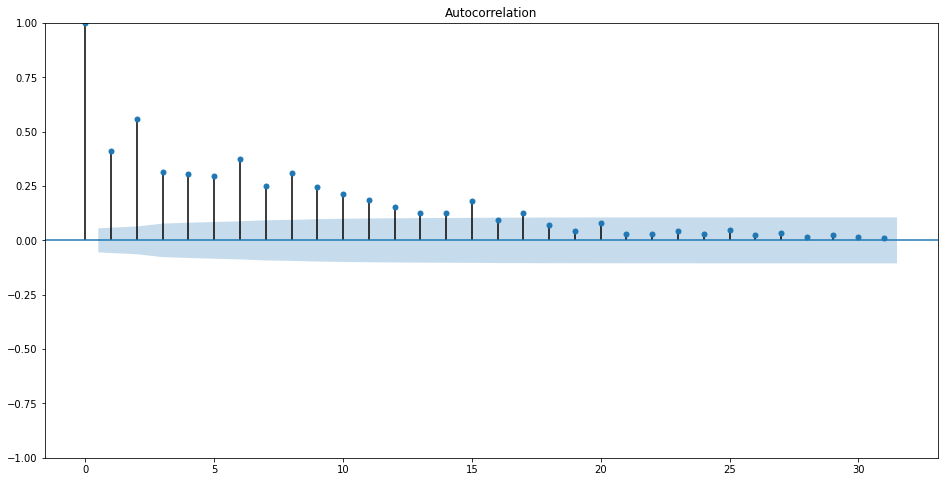

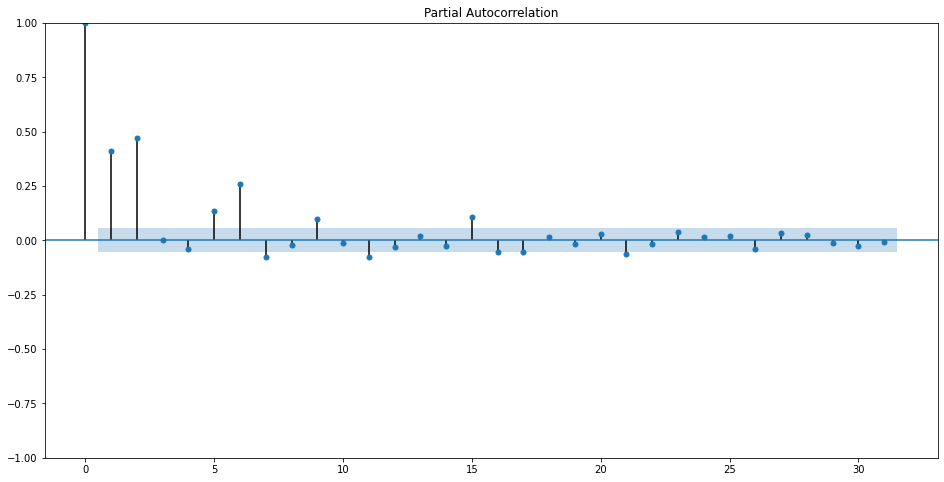

In [ ]:
#Auto-correlation
plt.rcParams["figure.figsize"] = (16,8)
plot_acf(Y**2)
plt.show()

#Partial Auto-correlation
plot_pacf(Y**2)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6562.189, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6617.136, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6603.162, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6562.764, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6637.775, Time=0.49 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6638.135, Time=0.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-6648.589, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-6650.683, Time=0.47 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-6672.850, Time=0.63 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-6707.710, Time=0.84 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=-6717.218, Time=0.98 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=-6728.582, Time=1.28 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=-6727.510, Time=1.18 sec
 ARIMA(9,1,1)(0,0,0)[0] intercept   : AIC=-6726.124, Time=3.52 sec
 ARIMA(8,1,1)(0,0,

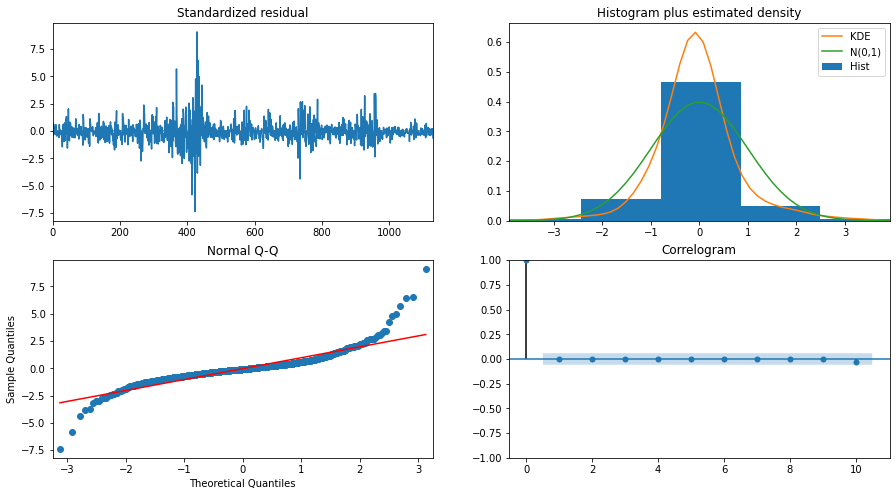

In [ ]:
#Selecting the mest ARIMA combination
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

model_autoARIMA.plot_diagnostics(figsize=(15,8))

plt.show()


Reference: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html

Produces a 2x2 plot grid with the following plots (ordered clockwise from top left):

1. Standardized residuals over time

2. Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference. (KDE - Epanechnikov kernel function)

3. Normal Q-Q plot, with Normal reference line. (finding the apt distribution)

4. Correlogram

In [ ]:
#As expected, better to use the AR > MA focused model
#Best model:  ARIMA(9,1,0)(0,0,0)[0]

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(9,1,0))  
arima_model = model.fit()

print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1132
Model:                 ARIMA(9, 1, 0)   Log Likelihood                3374.521
Date:                Sat, 27 Nov 2021   AIC                          -6729.042
Time:                        16:42:33   BIC                          -6678.734
Sample:                             0   HQIC                         -6710.036
                               - 1132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1204      0.015     -8.150      0.000      -0.149      -0.091
ar.L2          0.1164      0.015      7.789      0.000       0.087       0.146
ar.L3          0.0431      0.015      2.859      0.0

1       10.485826
2       10.486089
3       10.480642
4       10.480157
5       10.487683
          ...    
1128     9.958744
1129     9.961003
1130     9.962053
1131     9.959120
1132     9.952690
Name: Close, Length: 1132, dtype: float64

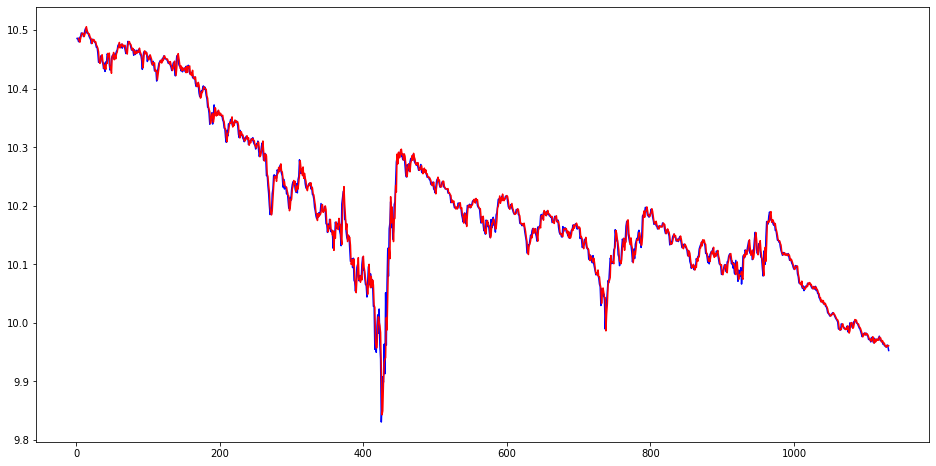

In [ ]:
#train,test -> after the log / difference
plt.plot(train_data,color='blue')

model = ARIMA(train_data[1:], order=(9,1,0))
results = model.fit()
plt.plot(results.fittedvalues[1:], color='red')

In [ ]:
model = ARIMA(train_data, order=(9,1,0))

In [ ]:
r = model.fit()


In [ ]:
x = r.predict(start=len(train_data),end=len(df))

1132    9.951732
1133    9.951597
1134    9.950551
1135    9.951411
1136    9.951199
          ...   
1254    9.950414
1255    9.950414
1256    9.950414
1257    9.950414
1258    9.950414
Name: predicted_mean, Length: 127, dtype: float64

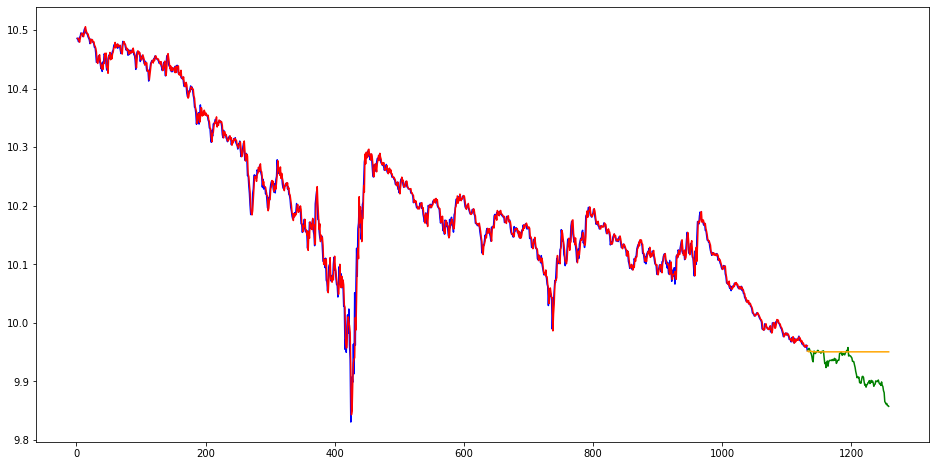

In [ ]:
plt.plot(train_data,color='blue')
plt.plot(results.fittedvalues[1:], color='red')
plt.plot(test_data,color='green')
plt.plot(x,color='orange')

Autoregressive models are used for 
1. Stationary (AR)
2. Trend (ARIMA)
3. Seasonality (SARIMA)


ARCH - AR(p) model applied to variance of time series



## 3 f) RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

final_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,random_state=0))
                             ])
# cv returns negative MAE, so *-1
scores = -1 * cross_val_score(final_pipeline, X, Y,
                              cv=5, #how many partitions they have
                              scoring='neg_mean_absolute_error')

In [ ]:
scores

array([0.07100342, 0.02887952, 0.00217016, 0.00208685, 0.0078143 ])

## 3 e) CNN + LSTM

Reference : https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

### define CNN model
cnn = Sequential()

cnn.add(Conv2D(...))

cnn.add(MaxPooling2D(...))

cnn.add(Flatten())
### define LSTM model
model = Sequential()

model.add(TimeDistributed(cnn, ...))

model.add(LSTM(..))

model.add(Dense(...))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import InputLayer, ConvLSTM1D, LSTM, Flatten, RepeatVector, Dense, TimeDistributed
from keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.losses import Huber

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [ ]:
X.shape

(1257, 16)

In [ ]:
Y.shape

(1257,)

In [ ]:
#train_test forms
btc_trf_scaled = scaler.fit_transform(X)
btc_trt_log = np.log(Y)

def build_model(hp):
    model = keras.Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=btc_trf_scaled.shape[1:]))

    # ConvLSTM1D
    convLSTM_hp_filters = hp.Int('filters', min_value=32, max_value=512, step=32)
    convLSTM_hp_kernel_size = hp.Choice('kernel_size', values=[3,5,7])
    convLSTM_activation = hp.Choice('convLSTM_activation', values=['selu', 'relu'])
    model.add(ConvLSTM1D(filters=convLSTM_hp_filters,
                       kernel_size=convLSTM_hp_kernel_size,
                       padding='same',
                       activation=convLSTM_activation,
                       use_bias=True,
                       bias_initializer='zeros'))

    # Flatten
    model.add(Flatten())

    # RepeatVector
    model.add(RepeatVector(5))

    # LSTM
    LSTM_hp_units = hp.Int('LSTM_units', min_value=32, max_value=512, step=32)
    LSTM_activation = hp.Choice('LSTM_activation', values=['selu', 'relu'])
    model.add(LSTM(units=LSTM_hp_units, activation=LSTM_activation, return_sequences=True))

    # TimeDistributed Dense
    dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32)
    dense_activation = hp.Choice('dense_activation', values=['selu', 'relu'])
    model.add(TimeDistributed(Dense(units=dense_units, activation=dense_activation)))

    # TimeDistributed Dense_Output
    model.add(Dense(1))

    # Set Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=Huber(),
                metrics=[RootMeanSquaredError()])
    
    return model
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective('root_mean_squared_error', direction='min'),
                     max_epochs=10,
                     factor=3)

early_stop = EarlyStopping(monitor='root_mean_squared_error', patience=5)

tuner.search(btc_trf_scaled, btc_trt_log, epochs=50, callbacks=[early_stop])

opt_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

ValueError: ignored

In [ ]:
df = process()
additional_features(df)

Enter the code of the model that you want to implement
MSFT
Loading the dataset for the MSFT


In [ ]:
length = len(df)
df_sub = df

X = np.array(df_sub.drop(columns = ['Close','momentum']))
Y = np.array(df_sub['Close'])

X_train = X[0:int(0.8*length)]
X_test = X[int(0.8*length):]
y_train = Y[0:int(0.8*length)]
y_test = Y[int(0.8*length):]

In [ ]:
#Using hp.Choice to find the optimal solution
def model_builder(hp):

  #Choosing the parameters
  CNN_filter = hp.Int("filter",min_value=32,max_value=512,step=32)
  CNN_kernel = hp.Choice('kernel',values=[1,3,5,7,9])
  CNN_activation = hp.Choice('activation',values=['relu','selu','softmax'])

  hp_learning_rate = hp.Choice('learning_rate', values=[0.1,1e-2, 1e-3, 1e-4])

  model = Sequential()
  model.add(Conv1D(1, (2,2), activation='relu', padding='causal', input_shape=(10,10,1)))
  model.add(MaxPooling1D(pool_size=(2, 2)))
  model.add(Flatten())


  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

 
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[RootMeanSquaredError()])

  return model

In [ ]:
#1 CNN
cnn = Sequential()
cnn.add(Conv1D(1, (2,2), activation='relu', padding='causal', input_shape=(10,10,1)))
cnn.add(MaxPooling1D(pool_size=(2, 2)))
cnn.add(Flatten())